# EMD: Emotional tweets

## Installing packages

In [373]:
! pip install unidecode
! pip install contractions
! pip install wordsegment
! pip install emoji --upgrade
! pip install plotly --upgrade
! python -m spacy download en_core_web_md

Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.5.0)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
wordsegment.load()
import pkg_resources
import emoji

### Mounting drive

In [397]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# PATH_TO_DIR = '/content/drive/My Drive/STUDIA/SEM 9/emd/'
PATH_TO_DIR = '/content/drive/My Drive/000 STUDIA/000 EKSPLORACJA MASYWNYCH DANYCH/'

Mounted at /content/drive


## Loading data

In [398]:
pd.set_option('display.max_colwidth', -1)

training_examples_url = PATH_TO_DIR + 'train.csv'
test_examples_url = PATH_TO_DIR + 'test.csv'

training_dataset = pd.read_csv(training_examples_url, delimiter=',')

print(training_dataset.shape)
print(training_dataset.describe())
training_dataset.head()

(5970, 3)
                        Id  Category          Tweet
count   5970                5970      5970         
unique  5964                4         5418         
top     637775514896306176  positive  Not Available
freq    2                   2888      548          


,Id,Category,Tweet
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it http://t.co/fmtcfUAdgj
2,635950258682523648,neutral,"Mar if you have an iOS device, you should download our app too: http://t.co/gl3tn2uDnD"
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on latest IOS which may account for problem the other day .. time it was replaced
4,636100906224848896,positive,Not sure how to start your publication on iOS? We'll be live helping with ask me anything sessions today and Friday http://t.co/KPqqGjjh3x


Detecting repeating or duplicated tweets with Counter (aside from Not Available, there are a few - are train.csv and test.csv the same?):

In [399]:
from collections import Counter

c = Counter(training_dataset["Tweet"].values)
c.most_common(10)

[('Not Available', 548),
 ('Finishing Jurassic park for like the 100th time tomorrow. Film class is gonna have a lot of reruns for me. All the batman films, Star Wars..',
  2),
 ("I really hope that Obama attends Serena's match on Saturday...Ciara's doing the National Anthem. Give us deze ratings biches.",
  2),
 ("Skimmed it  May not LIKE the SCOTUS decision but it's THE LAW. No offense, but your Pope? Climate Change? seriously? https://t.co/xg2ErQjdvH",
  2),
 ('@meldrum @iainmartin1 65-70% of Tory &amp; UKIP voters still want to renationalise the railways, as do the 1st &amp; 2nd place cands for Lab Leader.',
  2),
 ('@pperrin @nellesapelle Very wise. Hard to see UKIP going any further tho. Lab &amp; Tory split may open up new space like you said.',
  2),
 ('IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it http://t.co/fmtcfUAdgj',
  1),
 ('Mar if you have an iOS device, you should download our app too: http://t.co/gl3tn2uDnD',
  1),
 ('@jimmie_v

In [0]:
training_dataset = training_dataset.drop_duplicates(subset='Tweet')

### Class imbalance

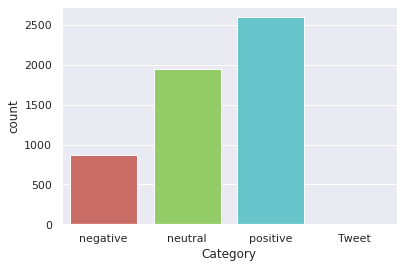

Category
Tweet       1   
negative    867 
neutral     1953
positive    2597
Name: Id, dtype: int64


In [401]:
sns.set(font_scale=1.0)
countplt=sns.countplot(x='Category', data=training_dataset, palette ='hls')
plt.show()

print(training_dataset.groupby('Category').count().Id)

In [402]:
training_dataset = training_dataset[(training_dataset["Category"] != 'Tweet') & (training_dataset["Tweet"] != "Not Available")]

X_train = list(training_dataset.Tweet)
X_train[:10]

['IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it http://t.co/fmtcfUAdgj',
 'Mar if you have an iOS device, you should download our app too: http://t.co/gl3tn2uDnD',
 '@jimmie_vanagon my phone does not run on latest IOS which may account for problem the other day .. time it was replaced',
 "Not sure how to start your publication on iOS? We'll be live helping with ask me anything sessions today and Friday http://t.co/KPqqGjjh3x",
 'Two Dollar Tuesday is here with Forklift 2, QuickKey for iOS and Suite for Pages for just $1.99 today:   http://t.co/BNMFOEACw5',
 "If you're not already signed up to test my iOS game, nows your chance! https://t.co/eZhIU6EDpQ",
 'YouTube Gaming Officially Launches On Web, Android, iOS On August 26: YouTube is finally going to r... http://t.co/qbhyA3kaWP #webseries',
 'YouTube Gaming Launches Tomorrow with iOS and Android Apps to Go Head-to-Head with Twitch http://t.co/yZOATToeJC #ios #game',
 "@astrill Yashan from BBC @

In [403]:
mapping = {'positive': 0, 'neutral': 1, 'negative': 2}

Y_train = list(training_dataset.Category.replace(mapping))
Y_train[:10]

[1, 1, 2, 0, 1, 1, 1, 1, 1, 0]

## [optional] Add more data from SemEval 2020 Task12

In [404]:
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset_semeval = pd.read_csv(training_examples_url, delimiter='\t')
training_dataset_semeval.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT,NaN,NaN


In [0]:
X_train_semeval = training_dataset_semeval['tweet'][training_dataset_semeval['subtask_a'] == 'OFF']
Y_train_semeval = [2] * len(X_train_semeval) #(training_dataset_semeval['subtask_a'][training_dataset_semeval['subtask_a'].notnull()] == 'OFF').astype(int) * 2

X_train_semeval = list(X_train_semeval)
Y_train_semeval = list(Y_train_semeval)

In [406]:
X_train_semeval[:10]

['@USER She should ask a few native Americans what their take on this is.',
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
 '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
 '@USER Liberals are all Kookoo !!!',
 '@USER @USER Oh noes! Tough shit.',
 '@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism',
 '@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo',
 '@USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL',
 '@USER @USER @USER gun control! That is all these kids are asking for!',
 '@USER @USER @USER @USER LOL!!!   Throwing the BULLSHIT Flag on such nonsense!!  #PutUpOrShutUp   #Kavanaugh   #MAGA   #CallTheVoteAlready URL']

In [407]:
X_train = X_train + X_train_semeval[:1169]
Y_train = Y_train + Y_train_semeval[:1169]
len(X_train), len(Y_train)

(6585, 6585)

## Preprocessing

In [408]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(Y_train),
                                            Y_train)
class_weights /= max(class_weights)
class_weights

array([0.75202156, 1.        , 0.95970516])

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags_remove_userlogins(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        elif chunk[0] == '@':
          continue
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)

from urllib.parse import urlparse
def remove_links(text):
  return ' '.join([word for word in text.split() if 'http' not in urlparse(word).scheme])


def preprocess_common(text):
    text = remove_links(text)
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags_remove_userlogins(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

In [410]:
for example in X_train[:10]:
  print(example)
  print(preprocess_common(example))
  print()
X_train = [preprocess_common(example) for example in X_train]

IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it http://t.co/fmtcfUAdgj
ios 9 app transport security. mm need to check if my 3rd party network pod supports it

Mar if you have an iOS device, you should download our app too: http://t.co/gl3tn2uDnD
mar if you have an ios device, you should download our app too

@jimmie_vanagon my phone does not run on latest IOS which may account for problem the other day .. time it was replaced
my phone does not run on latest ios which may account for problem the other day .. time it was replaced

Not sure how to start your publication on iOS? We'll be live helping with ask me anything sessions today and Friday http://t.co/KPqqGjjh3x
not sure how to start your publication on ios? we will be live helping with ask me anything sessions today and friday

Two Dollar Tuesday is here with Forklift 2, QuickKey for iOS and Suite for Pages for just $1.99 today:   http://t.co/BNMFOEACw5
two dollar tuesday is here with forklift

## Data exploration

In [411]:
# df.reset_index(inplace=True)
df = pd.DataFrame()
inv_map = {v: k for k, v in mapping.items()}

df["Processed"] = X_train
df["Label"] = Y_train
df["Category"] = df["Label"].apply(lambda x : inv_map[x])
df["Length"] = df["Processed"].apply(len)
df.head()

,Processed,Label,Category,Length
0,ios 9 app transport security. mm need to check if my 3rd party network pod supports it,1,neutral,86
1,"mar if you have an ios device, you should download our app too",1,neutral,62
2,my phone does not run on latest ios which may account for problem the other day .. time it was replaced,2,negative,103
3,not sure how to start your publication on ios? we will be live helping with ask me anything sessions today and friday,0,positive,117
4,"two dollar tuesday is here with forklift 2, quickkey for ios and suite for pages for just $1.99 today",1,neutral,101


In [412]:
df["Category"].value_counts()

positive    2597
negative    2035
neutral     1953
Name: Category, dtype: int64

### Tweets lengths in words

count    6585.000000
mean     106.382688 
std      41.928546  
min      5.000000   
25%      83.000000  
50%      108.000000 
75%      125.000000 
max      453.000000 
Name: Length, dtype: float64


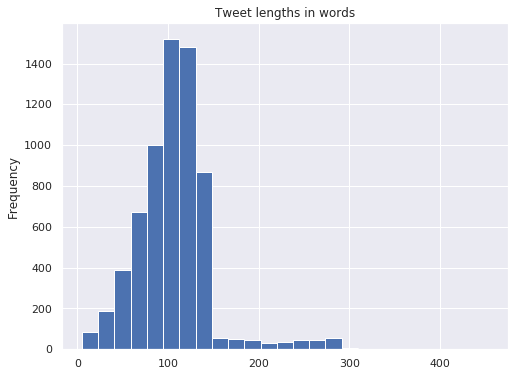

In [413]:
df["Length"].plot(bins=25, kind='hist', title='Tweet lengths in words', figsize=(8,6))
print(df["Length"].describe())

### Example Tweets per class

In [414]:
for label in mapping.keys():
  print(f"{label.upper()}:")
  sub_df = df[df['Category'] == label]
  random_sample = np.random.permutation([i for i in range(sub_df.shape[0])])[:5]
  print(sub_df["Processed"].values[random_sample])

POSITIVE:
['oracle is proud to be a sponsor of the dgi government customer service conference, august 26 in dc! learn more'
 'can i just go soak up the california sun on venice beach one more time before school starts?'
 "it is going to be on valentine's day so at least it will not be hot and alright i will go after your practice thursday"
 'the ford gt has won its 2nd vln race at the nordschleife, lexus of is 2nd in front of walkenhorst bmw z4'
 '"limited government leads to unlimited opportunity...the constitution is my owner\'s manual...10th amendment." gov rick perry dream 15']
NEUTRAL:
["2015 wyndham championship tee times, pairings for sunday's round in greensboro tiger woods was bounced from the sunday final pairin..."
 'oh there ue monday ok. i wonder what days we will have because of the pope'
 'the only time michelle obama would lower the flags on her property is if they were blocking the sun while she was sunbathing. chattanooga'
 'food giants call a truce w/ michelle obama,

### Stopwords removal

In [415]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
print(stopwords.words('english')[:5])

df["Processed_NoStopwords"] = df["Processed"].apply(
    lambda x : ' '.join([
      word for word in x.split() 
      if word not in stopwords.words('english') 
    ])
) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we']


### Analysis using `CountVectorizer` (words counts)

In [416]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,2))

for label in mapping.keys():
  print(f"{label.upper()}:")
  sub_df = df[df['Category'] == label]
  
  vec = cv.fit(sub_df["Processed_NoStopwords"])
  bow = vec.transform(sub_df["Processed_NoStopwords"])
  sum_words = bow.sum(axis=0)

  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  for wf in words_freq[:10]:
    print("\t", wf)
  bigrams_freq = list(filter(lambda x : len(x[0].split()) == 2, words_freq))
  for bf in bigrams_freq[:10]:
    print("\t\t", bf)

POSITIVE:
	 ('tomorrow', 442)
	 ('may', 416)
	 ('day', 301)
	 ('see', 241)
	 ('going', 231)
	 ('friday', 182)
	 ('time', 179)
	 ('new', 161)
	 ('sunday', 158)
	 ('one', 154)
		 ('magic mike', 80)
		 ('star wars', 79)
		 ('mike xxl', 79)
		 ('jurassic world', 76)
		 ('jurassic park', 73)
		 ('venice beach', 72)
		 ('labor day', 70)
		 ('pride parade', 61)
		 ('valentine day', 60)
		 ('mariah carey', 59)
NEUTRAL:
	 ('may', 404)
	 ('tomorrow', 241)
	 ('day', 157)
	 ('1st', 133)
	 ('like', 127)
	 ('going', 124)
	 ('time', 113)
	 ('new', 99)
	 ('sunday', 98)
	 ('get', 90)
		 ('jeb bush', 58)
		 ('joe biden', 51)
		 ('valentine day', 43)
		 ('tiger woods', 42)
		 ('windows 10', 41)
		 ('kurt cobain', 41)
		 ('michelle obama', 40)
		 ('tom cruise', 40)
		 ('sarah palin', 39)
		 ('labor day', 34)
NEGATIVE:
	 ('may', 227)
	 ('like', 184)
	 ('face', 164)
	 ('liberals', 162)
	 ('url', 143)
	 ('gun', 136)
	 ('trump', 133)
	 ('people', 120)
	 ('control', 118)
	 ('shit', 108)
		 ('gun control', 106)

### More analysis with `TfidfVectorizer`
Use `max_df=0.1` for (hopefully) better unique words insights

In [417]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.1)

for label in mapping.keys():
  print(f"{label.upper()}:")
  sub_df = df[df['Category'] == label]
  
  tf_vec = tf.fit(sub_df["Processed_NoStopwords"])
  tf_bow = tf_vec.transform(sub_df["Processed_NoStopwords"])
  tf_sum_words = tf_bow.sum(axis=0)

  words_freq = [(word, tf_sum_words[0, idx]) for word, idx in tf_vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  for wf in words_freq[:10]:
    print("\t", wf)
  bigrams_freq = list(filter(lambda x : len(x[0].split()) == 2, words_freq))
  for bf in bigrams_freq[:10]:
    print("\t\t", bf)



POSITIVE:
	 ('see', 27.70963408709759)
	 ('going', 27.45402484215707)
	 ('friday', 21.886849082956473)
	 ('time', 21.697347936193307)
	 ('jurassic', 19.719865624082395)
	 ('sunday', 18.792219489852123)
	 ('new', 18.505380509538742)
	 ('one', 18.297088620448903)
	 ('want', 17.7506947106338)
	 ('night', 16.705568715929424)
		 ('jurassic world', 12.129474584284846)
		 ('magic mike', 11.87524515115537)
		 ('mike xxl', 11.734351240821093)
		 ('star wars', 11.351604877032436)
		 ('venice beach', 11.221771743644386)
		 ('jurassic park', 10.701767697848988)
		 ('labor day', 9.642796797695619)
		 ('taylor swift', 9.507608265591214)
		 ('pride parade', 9.39593167704427)
		 ('valentine day', 9.349580576578653)
NEUTRAL:
	 ('day', 17.5280985387279)
	 ('going', 15.71330881714562)
	 ('like', 15.297763182925722)
	 ('1st', 14.173561709808412)
	 ('time', 14.092648561449193)
	 ('sunday', 11.876803096969777)
	 ('new', 11.776161165208984)
	 ('one', 11.59459243105789)
	 ('friday', 11.250540093012953)
	 ('ge

## Transforming sentences into average embedding vectors

In [418]:
import spacy

# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')

vectors = np.zeros(shape=(df.shape[0], 300), dtype=np.float64)
# process a sentence using the model

for idx, sent in enumerate(df["Processed"].values):
  doc = nlp(sent)
  vectors[idx, :] = doc.vector 
  if idx % 500 == 0:
    print("... processed", idx)


... processed 0
... processed 500
... processed 1000
... processed 1500
... processed 2000
... processed 2500
... processed 3000
... processed 3500
... processed 4000
... processed 4500
... processed 5000
... processed 5500
... processed 6000
... processed 6500


### **Principal Component Analysis** over mean embedding vectors

In [421]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principal_components = pca.fit_transform(vectors)
principal_df = pd.DataFrame(data = principal_components
             , columns = [
                          'principal component 1', 
                          'principal component 2', 
                          'principal component 3'
                          ])
pca_df = pd.concat([principal_df, df[['Category']]], axis = 1)
pca_df.head()


,principal component 1,principal component 2,principal component 3,Category
0,0.492322,-0.248833,-0.663064,neutral
1,-0.107336,-0.087497,-0.745384,neutral
2,-0.136233,-0.514065,-0.585558,negative
3,-0.378924,-0.075506,-0.624459,positive
4,0.753847,-0.152426,-0.543428,neutral


### Visualize PCA in three dimensions

In [422]:
# Import dependencies
import plotly
import plotly.graph_objs as go
import plotly.express as px

fig = go.Figure()

colors = [0, 1, 2]
for target, color in zip(sorted(mapping.keys()), colors):
  indicesToKeep = pca_df['Category'] == target
  fig.add_trace(
       go.Scatter3d(
        name=target,
        x=pca_df.loc[indicesToKeep, 'principal component 1'],
        y=pca_df.loc[indicesToKeep, 'principal component 2'],
        z=pca_df.loc[indicesToKeep, 'principal component 3'],
        mode='markers',
        marker=dict(
          size=3,
          color=color,   
          opacity=1.0
          ),
        ),
  )

fig.update_layout(
    showlegend=True,
    margin=dict(l=0, r=0, b=0, t=0),
    scene = dict(
      xaxis = dict(
          title='Principal component 1'),
      yaxis = dict(
          title='Principal component 2'),
      zaxis = dict(
          title='Principal component 3'),
    )
)
fig.show()


## Train+Test split

In [0]:
seed = 13

X_train = df["Processed"].values
X_train = df["Processed_NoStopwords"].values

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=seed)

## Test some `sklearn` machine-learning models

In [424]:
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC


def benchmark(clf, X_train, y_train, X_test, y_test, verbose=True):
  if verbose:
      print('_' * 80)
      print("Training: ")
      print(clf)

  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  score = metrics.accuracy_score(y_test, pred)

  if verbose:
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])

        if feature_names is not None:
            print("top 15 keywords per class:")
            for i, label in enumerate(target_names):
                top15 = np.argsort(clf.coef_[i])[-15:]
                print("%s: %s" % (label, " | ".join(feature_names[top15])))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                        target_names=target_names))

    print()
  clf_descr = str(clf).split('(')[0]
  return clf_descr, score

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train) 
X_test_tfidf = vectorizer.transform(X_test)
feature_names = vectorizer.get_feature_names()
target_names = list(map(lambda x : x[0], sorted(mapping.items(), key=lambda x : x[1])))

# Extracting 'select_chi2' best features by a chi-squared test, 
# if select_chi2 is set to number (k best features will be selected)
select_chi2 = None
if select_chi2:
  ch2 = SelectKBest(chi2, k=select_chi2)
  X_train_tfidf = ch2.fit_transform(X_train_tfidf, Y_train)
  X_test_tfidf = ch2.transform(X_test_tfidf)
  feature_names = [feature_names[i] for i
                    in ch2.get_support(indices=True)]

feature_names = np.asarray(feature_names) if feature_names else None

for clf, name in (
  (Perceptron(max_iter=50), "Perceptron"),
  (LogisticRegression(), "Logistic Regression"),
  (RandomForestClassifier(), "Random forest"),
  (SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet"), "SGD"),
  (BernoulliNB(alpha=.01), "Bernoulli Naive Bayes"),
  (LinearSVC(), "SVC")
  ):
  name, score = benchmark(clf, 
                        X_train_tfidf, Y_train, X_test_tfidf, Y_test,
                        verbose=False)
  print(name, score)


Perceptron 0.6309794988610479
LogisticRegression 0.659832953682612
RandomForestClassifier 0.6438876233864844
SGDClassifier 0.6507213363705391
BernoulliNB 0.6340167046317388
LinearSVC 0.6545178435839029


## GloVe + LSTM (62%)

In [437]:
from keras.preprocessing.text import Tokenizer

train_tokenizer = Tokenizer()
train_tokenizer.fit_on_texts(X_train)

Using TensorFlow backend.


In [438]:
max_lenght = 0
for line in X_train:
    max_lenght = max(max_lenght, len(line.split()))

max_lenght

48

In [0]:
max_lenght = 128

In [440]:
import os
from keras.layers import Embedding
from keras.initializers import Constant

embeddings_index = {}
with open(os.path.join(PATH_TO_DIR, 'glove.twitter.27B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

EMBEDDING_DIM = 100
vocab_size = len(train_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in train_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

embedding_layer_pretrained = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_lenght,
                            trainable=False,
                            mask_zero=True)

FileNotFoundError: ignored

In [0]:
from keras.preprocessing.sequence import pad_sequences

X_train_seq = train_tokenizer.texts_to_sequences(X_train)
X_train_seq = pad_sequences(X_train_seq, maxlen=max_lenght, padding='pre', value=0)

X_valid_seq = train_tokenizer.texts_to_sequences(X_valid)
X_valid_seq = pad_sequences(X_valid_seq, maxlen=max_lenght, padding='pre', value=0)

X_test_seq = train_tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_lenght, padding='pre', value=0)

X_train_seq.shape, X_valid_seq.shape, X_test_seq.shape

((4217, 128), (1055, 128), (1318, 128))

In [0]:
X_train_seq[0]    # exemplary sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  305,   13,    1,  692, 4511,   24,   91, 1080,   13,    1,
        692,  173,  186,  100,  357, 4512,   48], dtype=int32)

In [0]:
def get_model_checkpoint(name):
    return ModelCheckpoint(PATH_TO_DIR + 'models/' + name,
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

In [0]:
def plot_history(history):
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint

In [0]:
model = Sequential()

model.add(embedding_layer_pretrained)

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          1295900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 1,376,603
Trainable params: 80,703
Non-trainable params: 1,295,900
_________________________________________________________________




In [0]:
def to_one_hot(data, cls=None):
    if cls is None:
        cls = len(np.unique(data))
    sh = len(data)
    hot = np.zeros((sh, cls))
    hot[np.arange(sh), data] = 1
    return hot

In [0]:
model_name = 'lstm_30e'

history = model.fit(X_train_seq, to_one_hot(Y_train, 3), epochs=20, batch_size=64,
                    validation_data=(X_valid_seq, to_one_hot(Y_valid, 3)), 
                    callbacks=[get_model_checkpoint('best_' + model_name + '.h5')])

model.save_weights(PATH_TO_DIR + 'models/' + model_name + '.h5')

Train on 4217 samples, validate on 1055 samples
Epoch 1/20
4217/4217 [==============================] - 20s 5ms/step - loss: 0.7090 - acc: 0.6713 - val_loss: 0.7856 - val_acc: 0.6265

Epoch 00001: val_loss improved from inf to 0.78557, saving model to /content/drive/My Drive/STUDIA/SEM 9/emd/models/best_lstm_20e.h5
Epoch 2/20
4217/4217 [==============================] - 20s 5ms/step - loss: 0.7081 - acc: 0.6697 - val_loss: 0.7768 - val_acc: 0.6275

Epoch 00002: val_loss improved from 0.78557 to 0.77683, saving model to /content/drive/My Drive/STUDIA/SEM 9/emd/models/best_lstm_20e.h5
Epoch 3/20
4217/4217 [==============================] - 20s 5ms/step - loss: 0.6766 - acc: 0.6905 - val_loss: 0.8008 - val_acc: 0.6275

Epoch 00003: val_loss did not improve from 0.77683
Epoch 4/20
4217/4217 [==============================] - 20s 5ms/step - loss: 0.6696 - acc: 0.6950 - val_loss: 0.7878 - val_acc: 0.6284

Epoch 00004: val_loss did not improve from 0.77683
Epoch 5/20
4217/4217 [==============

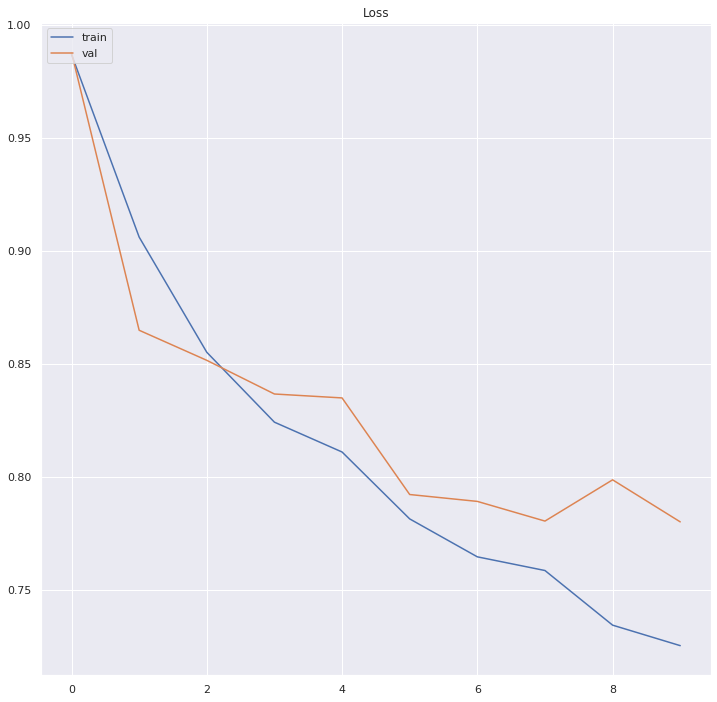

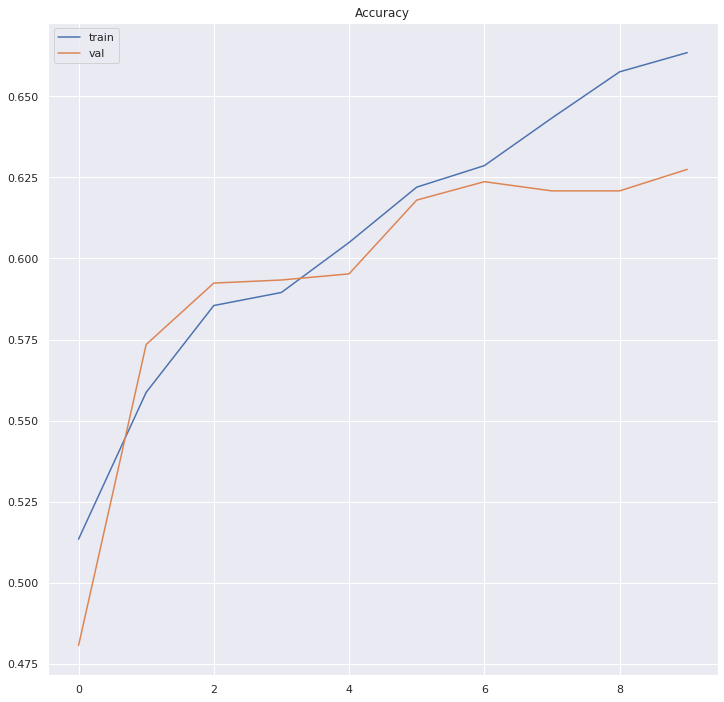

In [0]:
plot_history(history)

In [0]:
model.evaluate(X_test_seq, to_one_hot(Y_test, 3), batch_size=64, verbose=1)

1318/1318 [==============================] - 2s 2ms/step


[0.9577052555243415, 0.6153262517159191]

In [0]:
model.load_weights(PATH_TO_DIR + 'models/best_' + model_name + '.h5')

In [0]:
model.evaluate(X_test_seq, to_one_hot(Y_test, 3), batch_size=64, verbose=1)

1318/1318 [==============================] - 2s 2ms/step


[0.7886552369287054, 0.6244309557225889]

# Albert

In [0]:
! pip install simpletransformers
! git clone https://github.com/NVIDIA/apex
! pip install -v --no-cache-dir ./apex

In [0]:
def create_data_frame(X, Y):
    df = pd.DataFrame([])

    for x, y in zip(X, Y):
        row_df = pd.DataFrame([[x, y]])
        df = train_df.append(row_df)

    return df

In [0]:
train_df = create_data_frame(X_train, Y_train)
train_df.head()

,0,1
0,science behind the movie dinosaur dna extracti...,1
0,"biden on 2016 run ""i just do not know"" vice pr...",1
0,"there is a simple solution, just deport all th...",2
0,go follow this guys @sykeonair he is going to ...,0
0,biden gauging his 'emotional fuel' vice presid...,1


In [0]:
eval_df = create_data_frame(X_test, Y_test)
eval_df.head()

,0,1
0,someone go see jurassic world with me tomorrow...,0
0,@user sam was singing and they did not tell he...,2
0,@user @user mxm nigger thinks we give a fuck url,2
0,manitoba - ndp leader wab kinew on the carbon ...,2
0,"win10 build 10525 brings more color, better me...",0


In [0]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('albert', 'albert-base-v1', num_labels=3, weight=list(class_weights), args={'overwrite_output_dir': True})
model.train_model(train_df, args={'num_train_epochs': 3})

In [0]:
# Evaluate the model (without additional data)
from sklearn.metrics import accuracy_score
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

In [0]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('albert', 'albert-base-v1', num_labels=3, args={'output_dir': 'add_data_outputs/'})
model.train_model(train_df, args={'num_train_epochs': 5})

In [0]:
# Evaluate the model (without additional data)
from sklearn.metrics import accuracy_score
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

## GloVe + LSTM (62%)

In [0]:
from keras.preprocessing.text import Tokenizer

train_tokenizer = Tokenizer()
train_tokenizer.fit_on_texts(X_train)

Using TensorFlow backend.


### Creating submission file

In [0]:
test_examples_url = PATH_TO_DIR + 'test.csv'
test_dataset = pd.read_csv(test_examples_url, delimiter=',')
test_dataset.head()

,Id,Tweet
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
2,629023169169518592,Not Available
3,629179223232479232,Not Available
4,629186282179153920,If I make a game as a #windows10 Universal App...


In [0]:
len(test_dataset)

4000

In [0]:
len(test_dataset[test_dataset.Tweet =='Not Available'])

360

In [0]:
predictions, raw_outputs = model.predict(list(test_dataset.Tweet))

Converting to features started. Cache is not used.


In [0]:
test_dataset.head()

,Id,Tweet
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
2,629023169169518592,Not Available
3,629179223232479232,Not Available
4,629186282179153920,If I make a game as a #windows10 Universal App...


In [0]:
predictions[:10]

array([0, 2, 1, 1, 1, 1, 1, 1, 0, 1])

In [0]:
preds_df = test_dataset.drop(columns=['Tweet'])

In [0]:
preds_df['Category'] = predictions
preds_df.head()

,Id,Category
0,628949369883000832,0
1,628976607420645377,2
2,629023169169518592,1
3,629179223232479232,1
4,629186282179153920,1


In [0]:
training_dataset[training_dataset.Tweet == 'Not Available'].groupby('Category').count().Id

Category
negative     87
neutral     172
positive    289
Name: Id, dtype: int64

In [0]:
preds_df.loc[test_dataset.Tweet == 'Not Available', "Category"] = 0
preds_df.head()

,Id,Category
0,628949369883000832,0
1,628976607420645377,2
2,629023169169518592,0
3,629179223232479232,0
4,629186282179153920,1


In [0]:
mapping = {0: 'positive', 1: 'neutral', 2: 'negative'}
preds_df.Category = preds_df.Category.replace(mapping)
preds_df.head()

,Id,Category
0,628949369883000832,positive
1,628976607420645377,negative
2,629023169169518592,positive
3,629179223232479232,positive
4,629186282179153920,neutral


In [0]:
preds_df.to_csv(PATH_TO_DIR + 'submission.csv', index=False)

## Roberta

In [0]:
# from simpletransformers.classification import ClassificationModel

# model = ClassificationModel('roberta', 'roberta-base', num_labels=3, weight=list(class_weights), args={'output_dir': 'roberta_outputs/'})
# model.train_model(train_df, args={'num_train_epochs': 7})